In [57]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf, sys
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

print('tensorflow version: %s' % tf.__version__)
print('python version: %s' % sys.version)
print('python executable location: %s' % sys.executable)

# --------------------------------------------------------------
# --------------------------------------------------------------
%matplotlib inline
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import Callback


from helpers import *
import os, sys, tarfile, time
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.ticker import MaxNLocator
import pickle
import pandas as pd

params = {'legend.fontsize': 'x-large',
          'font.size'      : 11,
          'figure.figsize' : (17, 6),
          'axes.labelsize' : 'x-large',
          'axes.titlesize' : 'x-large',
          'axes.grid'      : 'on',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}

pylab.rcParams.update(params)


[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13163297060166042059
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 359006208
locality {
  bus_id: 1
}
incarnation: 6285852919717438163
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"
]
tensorflow version: 1.0.0
python version: 3.6.1 |Continuum Analytics, Inc.| (default, May 11 2017, 13:09:58) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
python executable location: /home/aind2/anaconda3/envs/aind-dog/bin/python
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
df_funding = pd.read_csv('data/funding.csv')
df_startup = pd.read_csv('data/startup.csv')
df_investor = pd.read_csv('data/investor.csv')
df_affiliations = pd.read_csv('data/affiliations.csv')
df_funding[:10]

,investor_id,investor_name,startup_id,startup_name,num_investments
0,835b33f4-4a34-4dc1-93c0-adf99aa976c4,Stan Chudnovsky,5345d177-29b5-4f35-b505-11250100b4b0,Scripted.com,1
1,835b33f4-4a34-4dc1-93c0-adf99aa976c4,Stan Chudnovsky,b15260db-16ab-4107-9a17-26e3bc6192b4,BranchOut,1
2,835b33f4-4a34-4dc1-93c0-adf99aa976c4,Stan Chudnovsky,76279f9a-62d5-4646-8e17-5c8b5f756d2c,The Extraordinaries,1
3,835b33f4-4a34-4dc1-93c0-adf99aa976c4,Stan Chudnovsky,1494e22e-d43b-437b-9352-a92318b4d3a1,Patreon,1
4,835b33f4-4a34-4dc1-93c0-adf99aa976c4,Stan Chudnovsky,3978cd95-d379-4a3c-b64b-4333cc998501,RepairPal,1
5,835b33f4-4a34-4dc1-93c0-adf99aa976c4,Stan Chudnovsky,85797d40-094b-4f95-a3a9-85c6a0d94100,Friend.ly,1
6,835b33f4-4a34-4dc1-93c0-adf99aa976c4,Stan Chudnovsky,d4eb63ae-7c78-4998-a74b-2fdcf114ac47,Goodreads,1
7,835b33f4-4a34-4dc1-93c0-adf99aa976c4,Stan Chudnovsky,b34b5dc2-40de-4749-b02f-f5d87f4cacca,Health Gorilla,1
8,835b33f4-4a34-4dc1-93c0-adf99aa976c4,Stan Chudnovsky,1d5eb78e-2cd9-4ef3-b8eb-ac65a87ffa46,Yodas.com,1
9,835b33f4-4a34-4dc1-93c0-adf99aa976c4,Stan Chudnovsky,0d4a4cbd-82be-4ffd-a595-bd3d5a9655d4,Wanelo,1


In [59]:
df_affiliations[:100]

,id,name,num_affiliated_founders
0,7e9709a7-3747-408a-b86a-30dc62ec15bf,Academic Earth,1
1,5b5ff3bf-b28d-418e-874b-d7f4c62877bc,Mixed Dimensions,1
2,368ffacf-c567-4ceb-a4fb-e7ad216674bd,ipadio,1
3,51aae8b3-ddbc-457b-a599-8d69de9a37bf,CTERA Networks,1
4,c81fcf1a-3418-4d4a-9eec-3c6aa7af7786,Cypromus,1
5,d737c8d5-8bff-4d0b-b1b2-d9a676111b2b,EOS Imaging,1
6,ec455eda-79de-40b3-84cb-7c69ad988a6b,Tomorrow,1
7,5137e562-f1e3-4426-9dda-91535e713758,HDS INTERNATIONAL,1
8,63bce598-8ead-4fc4-a5d4-3ba2d5f984d7,Epic Production Technologies,1
9,53253b32-25b8-4c66-849d-229cf9a8bcab,United Dental Care,1


In [60]:
a = df_funding['num_investments'].as_matrix()

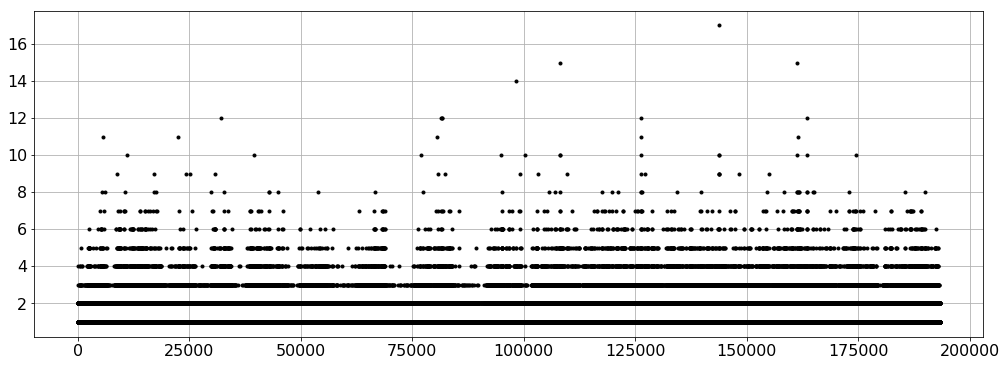

In [61]:
ax = plt.subplot(111)
ax.plot(a, 'k.')


(array([  1.56078000e+05,   2.56680000e+04,   7.64300000e+03,
          2.56700000e+03,   8.83000000e+02,   2.92000000e+02,
          1.26000000e+02,   3.90000000e+01,   1.70000000e+01,
          1.30000000e+01,   5.00000000e+00,   6.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00]),
 array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5,  19.5]),
 <a list of 19 Patch objects>)

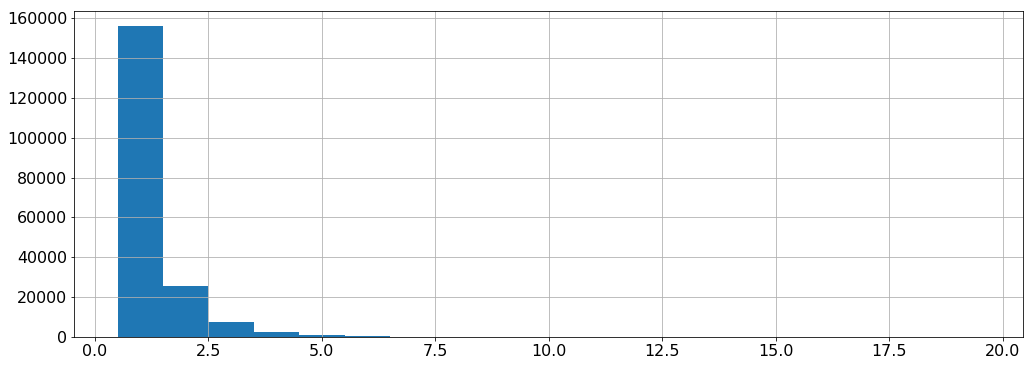

In [62]:
ax = plt.subplot(111)

ax.hist(a, bins=np.linspace(.5,19.5,20))


In [63]:
gr_inv = df_funding.groupby(by='investor_id').groups
gr_sta = df_funding.groupby(by='startup_id').groups

invID_to_i = {}
staID_to_j = {}
i_to_invID = {}
j_to_staID = {}

#.............................
i = -1
for k,v in gr_inv.items():
    i = i + 1
    invID_to_i[k] = i
    i_to_invID[i] = k
    
j = -1
for k,v in gr_sta.items():
    j = j + 1
    staID_to_j[k] = j
    j_to_staID[j] = k
#.............................
n_investments, n_investors, n_startups = (len(df_funding), len(invID_to_i), len(staID_to_j))

print('n_investments: \t%i' % (n_investments,)) 
print('n_investors: \t%i' % (n_investors,)) 
print('n_startups: \t%i' % (n_startups,)) 

n_investments: 	193341
n_investors: 	41838
n_startups: 	64764


# Matrix Factorization Model
### Obtain `R` and `R_indices`:

In [64]:
df_funding['i'] =  df_funding['investor_id'].apply(lambda row: invID_to_i[row])
df_funding['j'] =  df_funding['startup_id'].apply(lambda row: staID_to_j[row])
R_indices = df_funding[['i', 'j']].as_matrix()
R = np.ones(len(R_indices))
print('R.shape: %a \nR_indices.shape: %a' % (R.shape, R_indices.shape))

R.shape: (193341,) 
R_indices.shape: (193341, 2)


### Randomly sample indices of N/A entries in matrix `R`, then load the data into `R0_indices` and `R0=0`.
### Then, find `R0_indices` where there's collisions with `R_indices`.

In [65]:
# zero_examples = len(R)*10
# R0 = np.zeros((zero_examples))
# R0_indices = np.zeros((zero_examples, 2), dtype=np.int64)
# R0_indices[:,0] = np.random.choice(n_investors, zero_examples) 
# R0_indices[:,1] = np.random.choice(n_startups, zero_examples) 

# # This cell takes 60 min to run.
# start = time.time()
# collision_i = []

# for i, row in enumerate(R0_indices):
#     a = np.equal(row, R_indices)
#     if np.round(np.mean(a, axis=1)).astype('bool').any():
#         # checks if there's any row of R0_indices which is equal to some row of R_indices.
#         o = print_runtime(start,p_flag=False)
#         print('' + o)
#         print('collision detected at i: %i, row: %a' % (i, row))
#         collision_i.append(i)

# # .....................................................
# with open('data/collision_i.pkl', 'wb') as f:
#     pickle.dump(collision_i, f, pickle.HIGHEST_PROTOCOL)
# with open('data/R0_indices.pkl', 'wb') as f:
#     pickle.dump(R0_indices, f, pickle.HIGHEST_PROTOCOL)
    
# print_runtime(start)

In [66]:
with open('data/collision_i.pkl', 'rb') as f:
    collision_i = pickle.load(f)
    
with open('data/R0_indices.pkl', 'rb') as f:
    R0_indices = pickle.load(f)

""" Set the following exceptions in R0 to 1:
     R0[collision_i[...]] = 1"""

# correct the R0 vector where there are collisions with R.
for i in collision_i:
    R0[i] = 1


### Shuffle and Split Data:

In [67]:
shuffled_R_indices, shuffled_R = shuffler(np.concatenate((R_indices, R0_indices)), np.concatenate((R, R0)))
train_R_indices, train_R, cv_R_indices, cv_R, test_R_indices, test_R = split_data(shuffled_R_indices, shuffled_R)
print('train_R_indices.shape: \t%a' % (train_R_indices.shape,))
print('cv_R_indices.shape: \t%a' % (cv_R_indices.shape,))
print('test_R_indices.shape: \t%a' % (test_R_indices.shape,))

train_R_indices.shape: 	(1361120, 2)
cv_R_indices.shape: 	(340280, 2)
test_R_indices.shape: 	(425351, 2)


### Training:

Finished: construct_graph()... Runtime: 0 min 3 sec
NUM_EPOCHS: 10
LAMBDA: 0.0
k: 10
lr: 0.01
n_batches: 1329
BATCH_SIZE: 1024
start SGD iterations...
Epoch 1 ******************************
batch_no: 1329, _loss estimate: 0.1784, t= 25.36 sec
mae_train: 0.2191, **mae_cv: 0.2454**, mae_test: 0.2450,  mean(preds_cv): 0.2768, CHECKPOINT 0.2454
Epoch 2 ******************************
batch_no: 1329, _loss estimate: 0.1265, t= 38.14 sec
mae_train: 0.1365, **mae_cv: 0.2229**, mae_test: 0.2227,  mean(preds_cv): 0.2540, CHECKPOINT 0.2229
Epoch 3 ******************************
batch_no: 1329, _loss estimate: 0.0827, t= 35.13 sec
mae_train: 0.0552, **mae_cv: 0.1554**, mae_test: 0.1552,  mean(preds_cv): 0.1699, CHECKPOINT 0.1554
Epoch 4 ******************************
batch_no: 1329, _loss estimate: 0.0666, t= 34.50 sec
mae_train: 0.0417, **mae_cv: 0.1566**, mae_test: 0.1564,  mean(preds_cv): 0.1672
Epoch 5 ******************************
batch_no: 1329, _loss estimate: 0.0591, t= 24.96 sec
mae_trai

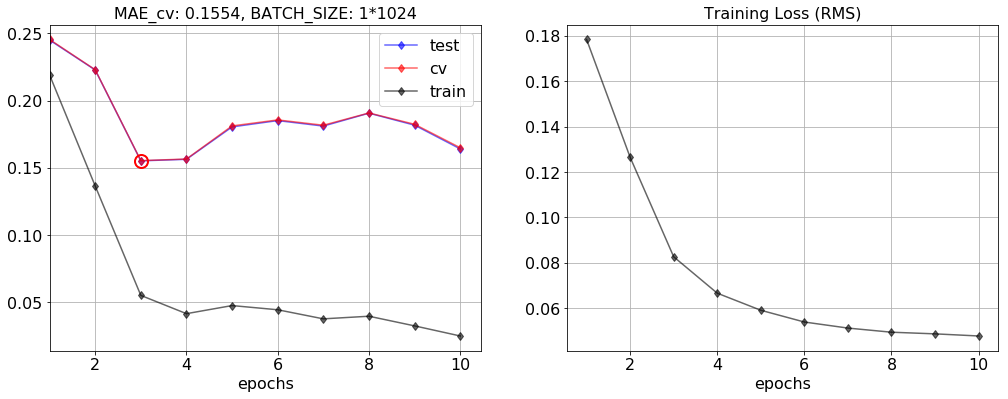

In [81]:
BATCH_SIZE = 1024
LAMBDA = 0.000
k = 10 # an important hyperparameter.
lr = 0.01
NUM_EPOCHS = 10
    
#.............................................. 
start = time.time()
print('Start: construct_graph()... ', end='\r')
train, loss, reg, R_indices, R, U, V, R_pred, X_UV = \
                        construct_graph(LAMBDA, k, lr, BATCH_SIZE, n_investors, n_startups)
o = print_runtime(start, p_flag=False)
print('Finished: construct_graph()... ' + o)
#.............................................. 

start = time.time()
mae_train_arr, mae_cv_arr, mae_test_arr, loss_arr, mean_preds, n_batches, preds_cv, preds_test, \
               _U, _V, _X_UV = \
                                 train_the_model(R_indices, R, train_R_indices, train_R, BATCH_SIZE, 
               NUM_EPOCHS, LAMBDA, k, lr, 
               train, loss, reg, U, V, R_pred,
               cv_R, cv_R_indices, test_R, test_R_indices, X_UV)
#.............................................. 
# plotting....
ax1, ax2 = plotter(mae_train_arr, mae_cv_arr, mae_test_arr, loss_arr, BATCH_SIZE)

#.............................................. 
print_runtime(start)
# os.system('afplay System/Library/Sounds/Ping.aiff')

In [82]:
_, accuracy, precision, recall, fpr = return_ROC_statistics(preds_cv, cv_R[:len(preds_cv)]) 
y_pred_cv_01, _,_,_,_ = return_ROC_statistics(preds_cv, cv_R[:len(preds_cv)], threshold=0.5) 

/home/aind2/miscelleneous_projects/VentureHub/helpers.py:55: RuntimeWarning: invalid value encountered in double_scalars
  precision = tp/float(tp+fp)


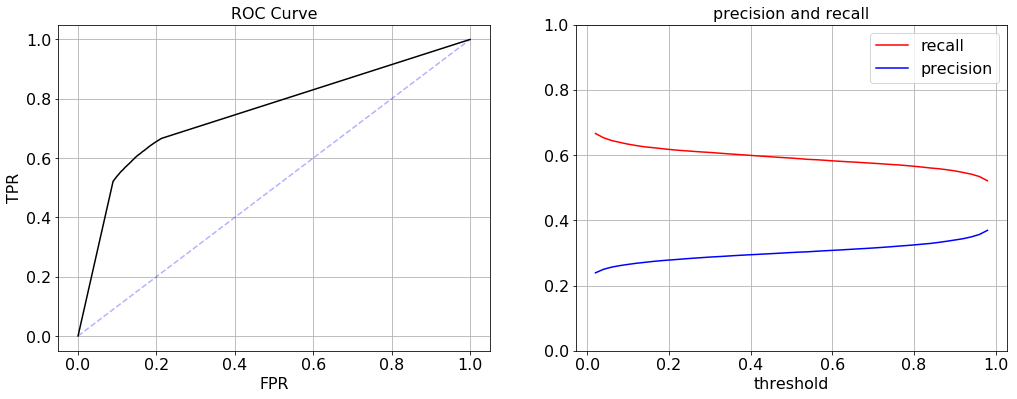

In [83]:
ax = plt.subplot(121)
ax.plot(fpr, recall, 'k')
ax.plot([0,1], [0,1],'b--', alpha=.3)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('ROC Curve')

ax = plt.subplot(122)
threshold = np.linspace(0,1,len(precision))
ax.plot(threshold[1:-1], recall[1:-1], 'r')
ax.plot(threshold[1:-1], precision[1:-1], 'b')
ax.set_ylim((0,1))
ax.set_xlabel('threshold')
ax.set_title('precision and recall')

ax.legend(['recall', 'precision'])
#.........................................

precision_cv:  0.30
recall_cv:  0.59
f1_score_cv:  0.40


<IPython.core.display.Latex object>

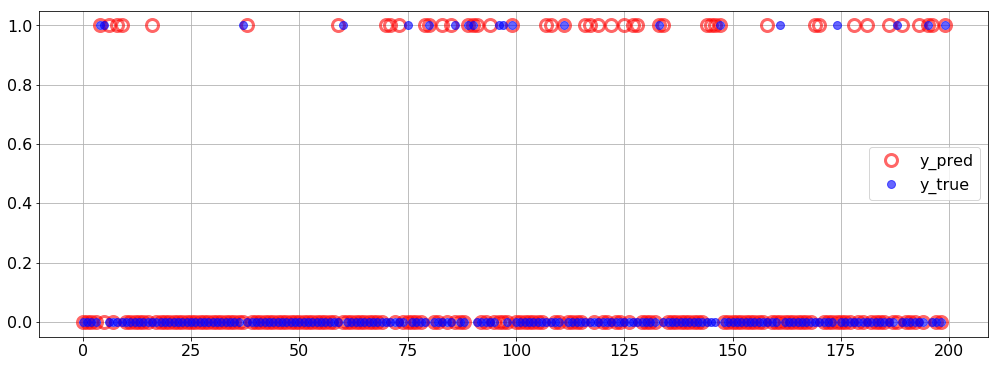

In [84]:
ax = plt.subplot(111)

ax.plot(y_pred_cv_01[:200],'ro', alpha=.6, markersize=12,  markerfacecolor='none', markeredgewidth=3)
ax.plot(cv_R[:200],'b.', alpha=.6, markersize=16)

ax.legend(('y_pred', 'y_true')) 

# ............................................................................
from sklearn.metrics import precision_recall_fscore_support as prf_score

y_true = cv_R[:len(preds_cv)]
y_pred = np.round(preds_cv)
threshold = 0.5

((_,precision_cv), (_,recall_cv), (_,f1_score_cv),_) = \
                                        prf_score(y_true=y_true, y_pred=y_pred) 

from IPython.display import Markdown, Latex

print('precision_cv:{:6.2f}\nrecall_cv:{:6.2f}\nf1_score_cv:{:6.2f}'.format(
                                                    precision_cv, recall_cv, f1_score_cv))
Latex('$$precision = \\frac{tp}{tp+fp}$$ $$$$ $$recall = \\frac{tp}{tp+fn}$$')

